Need to find an area covered by roughly 4 undithered FOVs for a full PhoSim simulation.

Want the area to have pixels with mean/typical depth= median survey depth. and not so scattered abs(max-min)depth.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import lsst.sims.maf.metricBundles as metricBundles
from findDC1Regions import findDC1Regions

In [2]:
help(findDC1Regions)

Help on function findDC1Regions in module findDC1Regions:

findDC1Regions(coaddBundle, dbpath, plotTestPlots=True, filterBand='i', threshold=0.0001, nside=256, returnAll=False)
    Find candidate regions for DC1 (based on how wildly the average depth in the region 
    differs from the survey median depth).
    
    Returns a bunch of stuff ...
    
    Required Parameters
    -------------------
      * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                           to a metricBundle object.
           NOTE: coaddBundle should have always have NoDither. If want to find regions based on a dithered
                 survey, the bundle should have the dithered data ALONG WITH the undithered one.
      * dbpath: str: path to the OpSim database.
    
    Optional Parameters
    -------------------
      * plotTestPlots: bool: set to False if dont want to plot things for debugging/testing code.
                             Default: True

In [3]:
workDir= os.getcwd()

### Based on NoDither coadded depth.

In [4]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''
    
    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz



In [5]:
startTime= time.time()
dbpath = path+'minion_1016_sqlite.db'
output= findDC1Regions(coaddBundle, dbpath, plotTestPlots= False,
                       filterBand= 'r', returnAll= True)

focusDither, output_rect, output_disc, simdata, pixels_in_FOV, pixelNum, pixRA, pixDec= output

print 'Time taken (s):', time.time()-startTime


############################################
## Getting RA, Dec for HEALPix pixels ...

############################################
## Getting simdata ...

############################################
## Getting pixels_in_FOV ...
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for NoDither: 2061.000000

############################################
## Finding good regions ...

############################################
## Finding good regions with threshold= 0.000100 using NoDither

## Mean survey depth for NoDither: 26.941664

## Mean survey depth for NoDither: 26.941664

############################################
## Plotting good regions with threshold= 0.000100 using NoDither

## Rectangular regions (using plotRegion):

## Cicular regions (using plotRegion):
Time taken (s): 405.83959198


In [6]:
pd.DataFrame([output_rect['goodFiducialIDs'],output_rect['diffMeanMedian'],
             output_rect['scatterInDepth'], output_rect['fiducialRA'],
             output_rect['fiducialDec']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec'])

""
goodFiducialIDs
DiffMeanMedian
DepthScatter
fiducialRA
fiducialDec


In [7]:
pd.DataFrame([output_disc['goodFiducialIDs'],output_disc['diffMeanMedian'],
             output_disc['scatterInDepth'], output_disc['fiducialRA'],
             output_disc['fiducialDec'], output_disc['contigIDs']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec',
             'contigIDs'])

""
goodFiducialIDs
DiffMeanMedian
DepthScatter
fiducialRA
fiducialDec
contigIDs


^^^ No region is good with threshold 0.0001 for NoDither .. 

### Based on SequentialHexDitherPerNight coadded depth.

In [8]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_SequentialHexDitherPerNight.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for SequentialHexDitherPerNight:  coaddM5Data_masked_r_SequentialHexDitherPerNight.npz




############################################
## Getting RA, Dec for HEALPix pixels ...

############################################
## Getting simdata ...

############################################
## Getting pixels_in_FOV ...
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for SequentialHexDitherPerNight: 2249.000000

############################################
## Finding good regions ...

############################################
## Finding good regions with threshold= 0.000100 using SequentialHexDitherPerNight

## Mean survey depth for SequentialHexDitherPerNight: 27.008246

## Mean survey depth for SequentialHexDitherPerNight: 27.008246
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes

############################################
## Plotting good regions with threshold= 0.000100 using SequentialHexDitherPerNig

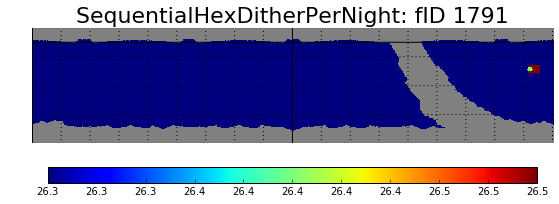

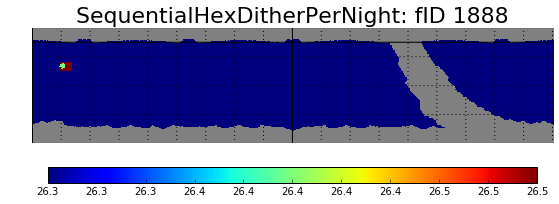


## Cicular regions (using plotRegion):


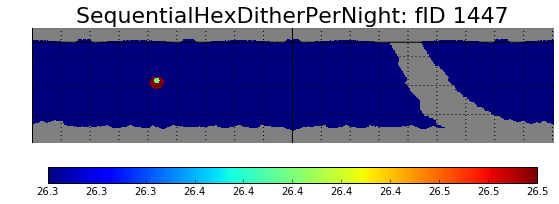

Time taken (s): 551.031731129


In [9]:
startTime= time.time()
dbpath = path+'minion_1016_sqlite.db'
output= findDC1Regions(coaddBundle, dbpath, plotTestPlots= False,
                       filterBand= 'r', returnAll= True)

focusDither, output_rect, output_disc, simdata, pixels_in_FOV, pixelNum, pixRA, pixDec= output

print 'Time taken (s):', time.time()-startTime

In [10]:
pd.DataFrame([output_rect['goodFiducialIDs'],output_rect['diffMeanMedian'],
             output_rect['scatterInDepth'], output_rect['fiducialRA'],
             output_rect['fiducialDec']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec'])

,0,1
goodFiducialIDs,1.791000e+03,1888.000000
DiffMeanMedian,6.268360e-07,0.000032
DepthScatter,4.555302e-01,0.364538
fiducialRA,3.423892e+00,2.778955
fiducialDec,-3.314060e-01,-0.295396


^^ So we have 2 rectangular regions with the average depth within 0.0001 of the median survey depth.

In [11]:
pd.DataFrame([output_disc['goodFiducialIDs'],output_disc['diffMeanMedian'],
             output_disc['scatterInDepth'], output_disc['fiducialRA'],
             output_disc['fiducialDec'], output_disc['contigIDs']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec',
             'contigIDs'])

,0
goodFiducialIDs,1447
DiffMeanMedian,8.51566e-05
DepthScatter,0.403503
fiducialRA,1.64132
fiducialDec,-0.496321
contigIDs,"[1447, 1323, 1431, 1333]"


^^ So we have only 1 circular region with the average depth within 0.0001 of the median survey depth.

### Based on RandomDitherFieldPerVisit coadded depth.

In [12]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for RandomDitherFieldPerVisit:  coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz




############################################
## Getting RA, Dec for HEALPix pixels ...

############################################
## Getting simdata ...

############################################
## Getting pixels_in_FOV ...
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for RandomDitherFieldPerVisit: 2250.000000

############################################
## Finding good regions ...

############################################
## Finding good regions with threshold= 0.000100 using RandomDitherFieldPerVisit

## Mean survey depth for RandomDitherFieldPerVisit: 27.007376

## Mean survey depth for RandomDitherFieldPerVisit: 27.007376
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Something is wrong. Should have only one FOV corresponding to the central pixel.

############################################
## Plott

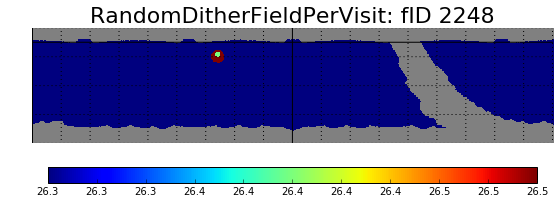

Time taken (s): 540.525141001


In [13]:
startTime= time.time()
dbpath = path+'minion_1016_sqlite.db'
output= findDC1Regions(coaddBundle, dbpath, plotTestPlots= False,
                       filterBand= 'r', returnAll= True)

focusDither, output_rect, output_disc, simdata, pixels_in_FOV, pixelNum, pixRA, pixDec= output

print 'Time taken (s):', time.time()-startTime

In [14]:
pd.DataFrame([output_rect['goodFiducialIDs'],output_rect['diffMeanMedian'],
             output_rect['scatterInDepth'], output_rect['fiducialRA'],
             output_rect['fiducialDec']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec'])

""
goodFiducialIDs
DiffMeanMedian
DepthScatter
fiducialRA
fiducialDec


In [15]:
pd.DataFrame([output_disc['goodFiducialIDs'],output_disc['diffMeanMedian'],
             output_disc['scatterInDepth'], output_disc['fiducialRA'],
             output_disc['fiducialDec'], output_disc['contigIDs']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec',
             'contigIDs'])

,0
goodFiducialIDs,2248.000000
DiffMeanMedian,0.000004
DepthScatter,0.348380
fiducialRA,0.906446
fiducialDec,-0.177460
contigIDs,NaN


^^^ Only one circular region with average depth within 0.0001 of the median survey depth. No rectangular regions. 

Not sure why contigIDs are not coming out right.

In [16]:
from intermediates import findContigFOVs

In [17]:
findContigFOVs(0.906446, -0.177460, 2248, 0.0305, simdata,
                   disc= True, nside= 256)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Something is wrong. Should have only one FOV corresponding to the central pixel.


In [18]:
findContigFOVs(0.906446, -0.177460, 2248, 0.0305, simdata,
                   disc= True, nside= 512)

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Something is wrong. Should have only one FOV corresponding to the central pixel.
